In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import numpy as np
import torch as ch
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, StopStringCriteria, StoppingCriteriaList, DataCollatorForSeq2Seq
from matplotlib import pyplot as plt

In [3]:
from hot_pate.samplers import IndependentSampler, CoordinatedSampler
from hot_pate.aggregators import MaxAggregator
from hot_pate.utils import create_histograms, estimate_transfer_support, estimate_transfer_mass, get_model_and_tokenizer, load_instruction_dataset, create_instruction_teacher_prompts, create_stop_fn
from hot_pate.hot_pate import *

In [4]:
NUM_TEACHERS = 512
NUM_EXAMPLES_PER_TEACHER = 10

model_name = "meta-llama/Llama-3.1-8B"
model, tokenizer = get_model_and_tokenizer(model_name)
dataset = load_instruction_dataset()
teacher_prompts = create_instruction_teacher_prompts(
    dataset, NUM_TEACHERS, NUM_EXAMPLES_PER_TEACHER, seed=0
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
ind_sampler = IndependentSampler(temperature=0.6)
coo_sampler = CoordinatedSampler(temperature=0.6)

In [6]:
def get_max_votes_and_margins(logits, sampler, num_samples, num_repetitions):
    samples = sampler.sample(logits, num_samples * num_repetitions)
    histograms = create_histograms(samples, model.vocab_size)
    max_votes_outputs = histograms.max(dim=-1)
    max_votes = max_votes_outputs.values
    histograms[ch.arange(num_samples * num_repetitions), max_votes_outputs.indices] = 0
    second_max_votes = histograms.max(dim=-1).values
    margins = max_votes - second_max_votes
    max_votes = max_votes.view(num_samples, num_repetitions)
    margins = margins.view(num_samples, num_repetitions)
    max_votes = max_votes.max(dim=-1).values.type(ch.float32)
    margins = margins.max(dim=-1).values.type(ch.float32)
    max_votes_stats = max_votes.mean().item(), max_votes.std().item() / np.sqrt(num_samples)
    margins_stats = margins.mean().item(), margins.std().item() / np.sqrt(num_samples)
    return max_votes_stats + margins_stats

In [7]:
def plot_max_metrics(
    metric_name,
    ind_values,
    ind_values_std,
    coo_values,
    coo_values_std,
    tokens,
    tokenizer,
    bar_alpha = 0.75,
    save_path = None,
    num_repetitions_for_max_votes = 10,
):
    ind_values       = np.asarray(ind_values)
    ind_values_std   = np.asarray(ind_values_std)
    coo_values       = np.asarray(coo_values)
    coo_values_std   = np.asarray(coo_values_std)
    tokens           = np.asarray(tokens)

    if not (
        ind_values.shape
        == ind_values_std.shape
        == coo_values.shape
        == coo_values_std.shape
        == tokens.shape
    ):
        raise ValueError("All input arrays must have the same length")

    x       = np.arange(len(tokens))
    labels  = [tokenizer.decode([tok]).replace("\n", "\\n") for tok in tokens]
    width   = 0.35

    fig, ax = plt.subplots(figsize=(max(6, len(tokens) * 0.6), 4))

    # Draw grid behind bars
    ax.set_axisbelow(True)
    ax.grid(axis="y", linestyle="--", alpha=0.4, zorder=0)

    # Bars with transparency
    ax.bar(
        x - width / 2,
        ind_values,
        width,
        yerr=ind_values_std,
        capsize=3,
        label="Independent",
        alpha=bar_alpha,
        zorder=2,
    )
    ax.bar(
        x + width / 2,
        coo_values,
        width,
        yerr=coo_values_std,
        capsize=3,
        label="Coordinated",
        alpha=bar_alpha,
        zorder=2,
    )

    try_text = f"tries" if num_repetitions_for_max_votes > 1 else "try"
    ax.set_ylabel(f"{metric_name} with {num_repetitions_for_max_votes} {try_text}")
    ax.set_xlabel("Generated token")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.legend()
    fig.tight_layout()

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path)
    plt.show()

Independent Max T | Coordinated Max T | Prefix
347.4 (1.1) | 425.8 (8.8) | 
369.1 (1.0) | 445.7 (9.0) | What
471.0 (0.6) | 486.1 (5.6) | What's
226.3 (1.0) | 355.5 (10.8) | What's the
140.0 (0.9) | 343.2 (11.0) | What's the most
257.8 (1.0) | 416.8 (9.5) | What's the most delicious
407.5 (0.9) | 456.0 (7.5) | What's the most delicious cuisine
495.4 (0.4) | 496.8 (4.0) | What's the most delicious cuisine in
509.8 (0.1) | 508.8 (1.9) | What's the most delicious cuisine in the
489.2 (0.5) | 502.2 (2.9) | What's the most delicious cuisine in the world
What's the most delicious cuisine in the world?




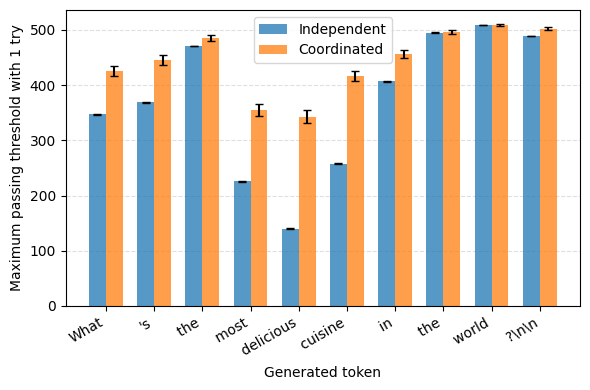

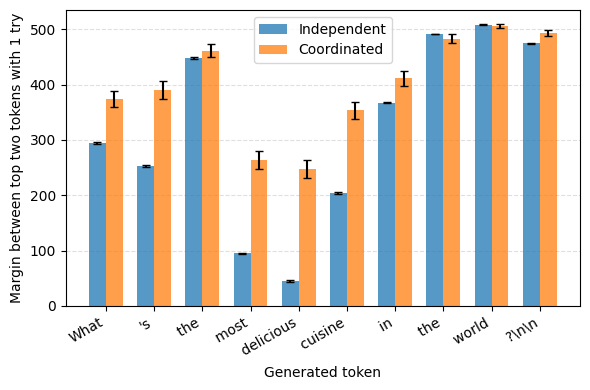

361.0 (1.3) | 505.1 (2.5) | 
380.7 (1.5) | 511.2 (0.5) | What
476.5 (0.7) | 511.8 (0.2) | What's
236.6 (1.5) | 458.2 (11.2) | What's the
152.8 (1.3) | 470.1 (11.4) | What's the most
271.2 (1.5) | 508.4 (1.4) | What's the most delicious
418.6 (1.2) | 508.0 (2.4) | What's the most delicious cuisine
500.0 (0.5) | 511.8 (0.1) | What's the most delicious cuisine in
511.2 (0.2) | 512.0 (0.0) | What's the most delicious cuisine in the
494.1 (0.7) | 511.8 (0.2) | What's the most delicious cuisine in the world
What's the most delicious cuisine in the world?




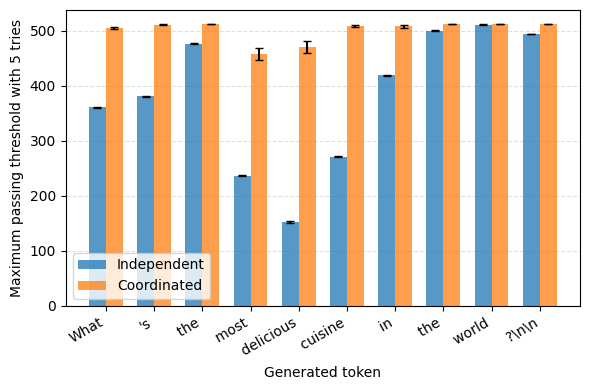

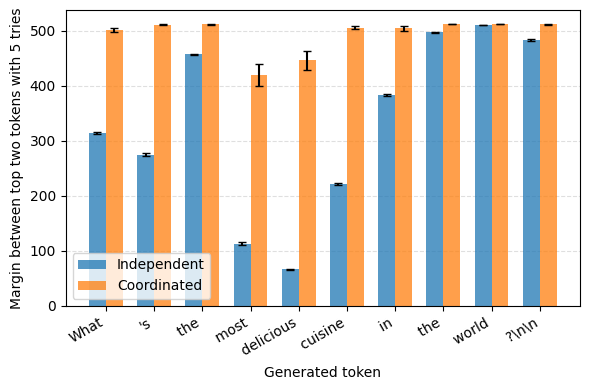

366.2 (1.5) | 508.3 (0.9) | 
381.5 (1.5) | 511.0 (0.9) | What
477.7 (0.6) | 512.0 (0.0) | What's
242.9 (1.4) | 506.4 (2.0) | What's the
154.1 (1.5) | 503.8 (3.1) | What's the most
275.8 (1.1) | 510.4 (1.0) | What's the most delicious
421.0 (1.3) | 510.1 (1.9) | What's the most delicious cuisine
502.3 (0.5) | 512.0 (0.0) | What's the most delicious cuisine in
511.5 (0.2) | 512.0 (0.0) | What's the most delicious cuisine in the
497.8 (0.7) | 512.0 (0.0) | What's the most delicious cuisine in the world
What's the most delicious cuisine in the world?




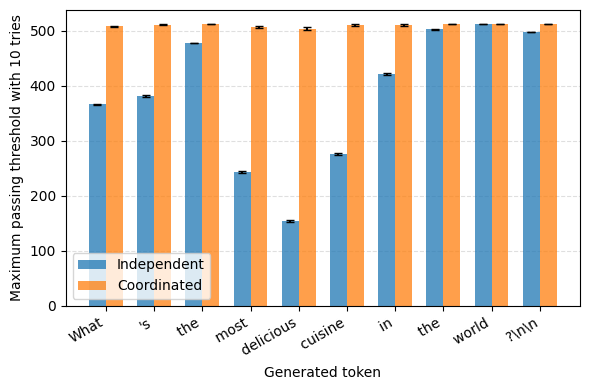

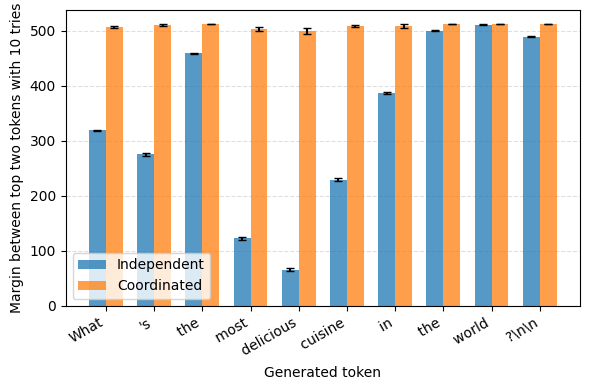

350.0 (1.1) | 430.7 (9.4) | 
369.3 (1.0) | 448.8 (8.1) | What
464.1 (0.6) | 482.2 (5.8) | What is
148.9 (0.9) | 317.0 (11.2) | What is the
436.8 (0.8) | 473.3 (5.4) | What is the best
510.2 (0.1) | 511.9 (0.0) | What is the best way
123.6 (0.9) | 345.3 (10.4) | What is the best way to
104.7 (0.9) | 381.4 (10.6) | What is the best way to learn
310.2 (1.0) | 392.7 (9.3) | What is the best way to learn to
358.0 (1.1) | 456.0 (7.8) | What is the best way to learn to play
242.5 (0.7) | 460.2 (8.0) | What is the best way to learn to play the
476.3 (0.5) | 478.9 (5.6) | What is the best way to learn to play the guitar
What is the best way to learn to play the guitar?




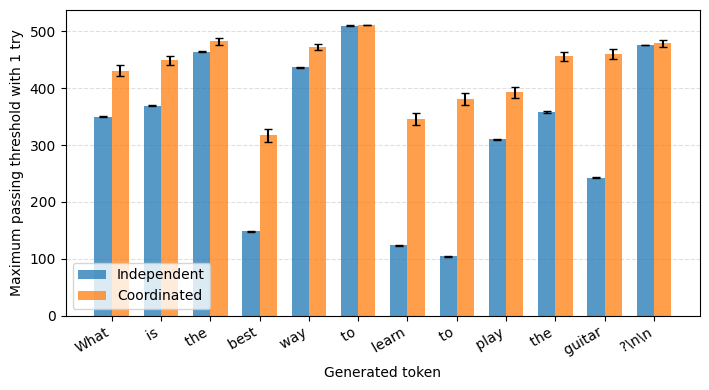

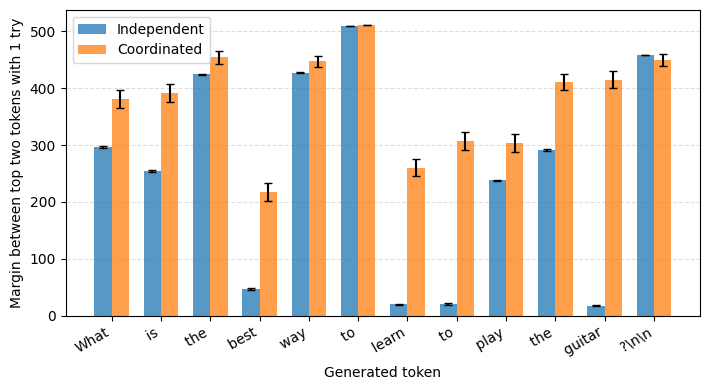

359.6 (1.0) | 502.1 (3.1) | 
380.1 (1.5) | 509.0 (2.2) | What
470.4 (1.1) | 511.1 (0.2) | What is
161.5 (1.7) | 458.2 (12.2) | What is the
446.2 (0.8) | 507.2 (1.2) | What is the best
511.8 (0.1) | 512.0 (0.0) | What is the best way
136.2 (1.6) | 489.4 (6.6) | What is the best way to
113.3 (1.4) | 495.2 (4.0) | What is the best way to learn
324.8 (1.7) | 487.0 (6.0) | What is the best way to learn to
369.0 (1.5) | 511.0 (0.4) | What is the best way to learn to play
249.9 (1.2) | 511.5 (0.2) | What is the best way to learn to play the
480.3 (1.1) | 509.6 (1.0) | What is the best way to learn to play the guitar
What is the best way to learn to play the guitar?




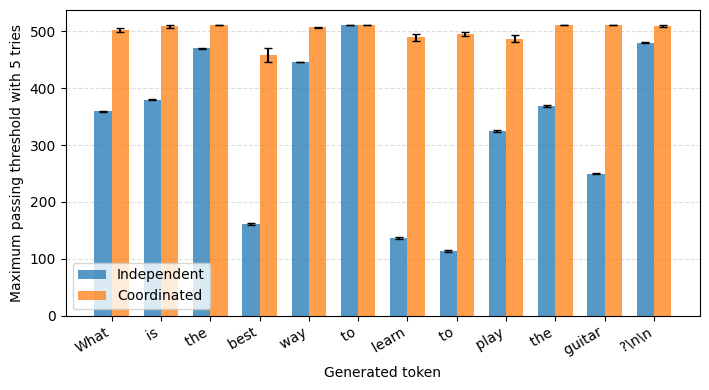

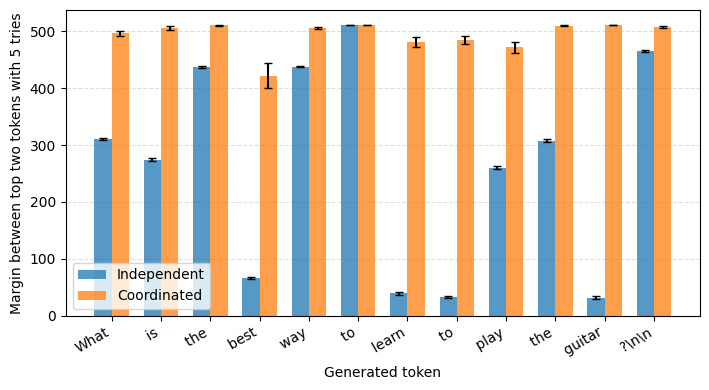

362.9 (2.0) | 508.7 (1.2) | 
382.0 (1.3) | 512.0 (0.0) | What
473.0 (1.8) | 511.8 (0.1) | What is
165.0 (1.7) | 472.5 (12.4) | What is the
447.3 (1.2) | 510.2 (0.8) | What is the best
511.8 (0.1) | 512.0 (0.0) | What is the best way
137.5 (1.9) | 499.3 (2.8) | What is the best way to
117.1 (1.6) | 507.9 (1.4) | What is the best way to learn
326.4 (2.2) | 505.7 (2.1) | What is the best way to learn to
371.3 (1.1) | 511.7 (0.2) | What is the best way to learn to play
256.3 (2.7) | 512.0 (0.0) | What is the best way to learn to play the
482.7 (1.0) | 512.0 (0.0) | What is the best way to learn to play the guitar
What is the best way to learn to play the guitar?




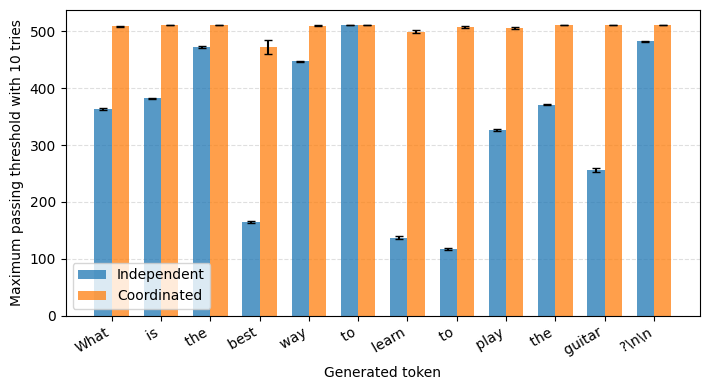

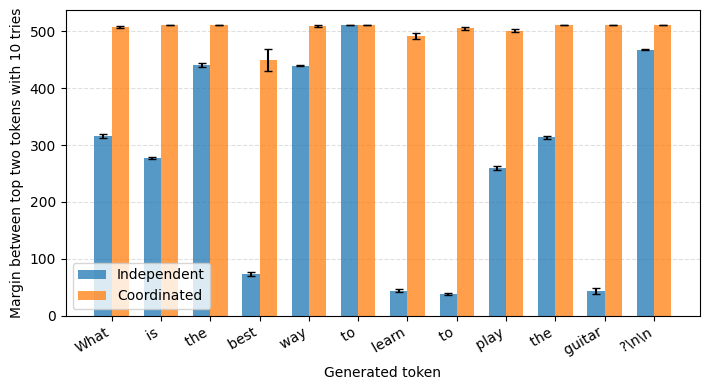

349.4 (1.0) | 433.3 (8.9) | 
247.9 (1.1) | 423.4 (9.3) | Is
229.1 (1.0) | 388.7 (10.6) | Is it
459.1 (0.7) | 499.0 (3.6) | Is it legal
76.3 (0.7) | 382.7 (11.0) | Is it legal to
264.4 (1.2) | 427.1 (10.1) | Is it legal to claim
217.1 (1.1) | 434.7 (8.6) | Is it legal to claim a
454.3 (0.8) | 485.6 (5.8) | Is it legal to claim a deduction
250.2 (1.1) | 435.8 (8.9) | Is it legal to claim a deduction for
126.4 (0.9) | 410.7 (10.7) | Is it legal to claim a deduction for a
507.4 (0.2) | 507.5 (2.4) | Is it legal to claim a deduction for a home
182.2 (0.7) | 393.6 (9.6) | Is it legal to claim a deduction for a home office
276.0 (1.1) | 390.3 (9.9) | Is it legal to claim a deduction for a home office in
266.6 (1.2) | 394.9 (10.1) | Is it legal to claim a deduction for a home office in the
511.7 (0.1) | 511.0 (0.9) | Is it legal to claim a deduction for a home office in the state
250.4 (1.3) | 425.8 (9.1) | Is it legal to claim a deduction for a home office in the state of
406.6 (0.9) | 489.7 

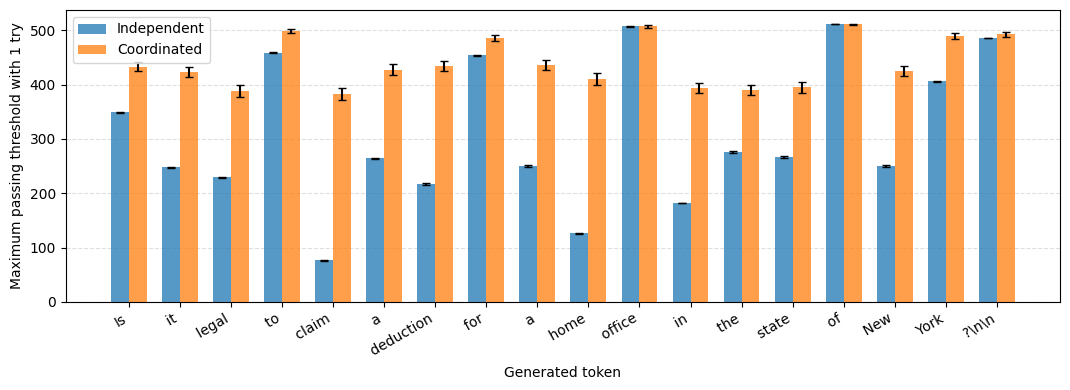

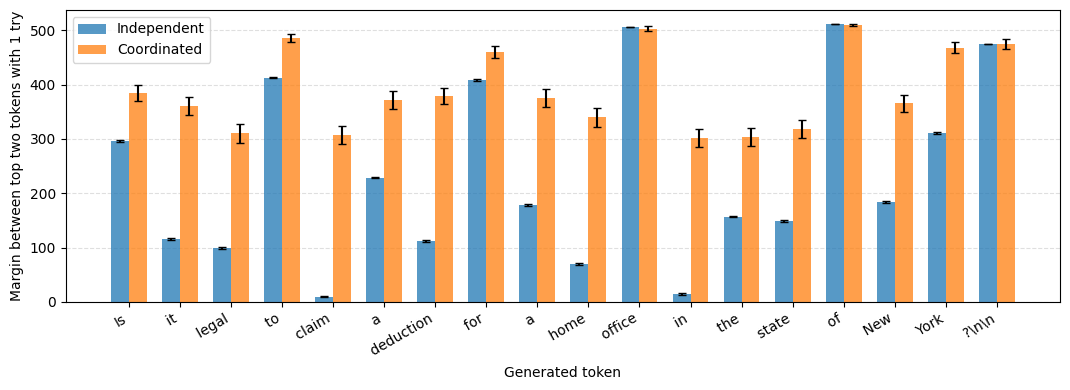

359.9 (1.4) | 503.9 (3.3) | 
260.9 (1.6) | 497.4 (5.3) | Is
245.2 (1.8) | 504.2 (2.9) | Is it
466.2 (1.1) | 512.0 (0.1) | Is it legal
84.6 (1.0) | 495.7 (7.7) | Is it legal to
276.4 (1.5) | 505.4 (3.8) | Is it legal to claim
226.8 (1.6) | 508.5 (1.1) | Is it legal to claim a
465.3 (0.8) | 512.0 (0.0) | Is it legal to claim a deduction
262.6 (1.4) | 511.0 (0.5) | Is it legal to claim a deduction for
141.2 (1.6) | 509.0 (1.2) | Is it legal to claim a deduction for a
509.4 (0.3) | 512.0 (0.0) | Is it legal to claim a deduction for a home
193.7 (1.2) | 493.4 (5.8) | Is it legal to claim a deduction for a home office
287.9 (1.4) | 496.7 (5.4) | Is it legal to claim a deduction for a home office in
279.1 (1.0) | 486.0 (7.1) | Is it legal to claim a deduction for a home office in the
512.0 (0.0) | 512.0 (0.0) | Is it legal to claim a deduction for a home office in the state
261.9 (1.7) | 502.6 (2.9) | Is it legal to claim a deduction for a home office in the state of
415.0 (1.4) | 511.6 (0.1)

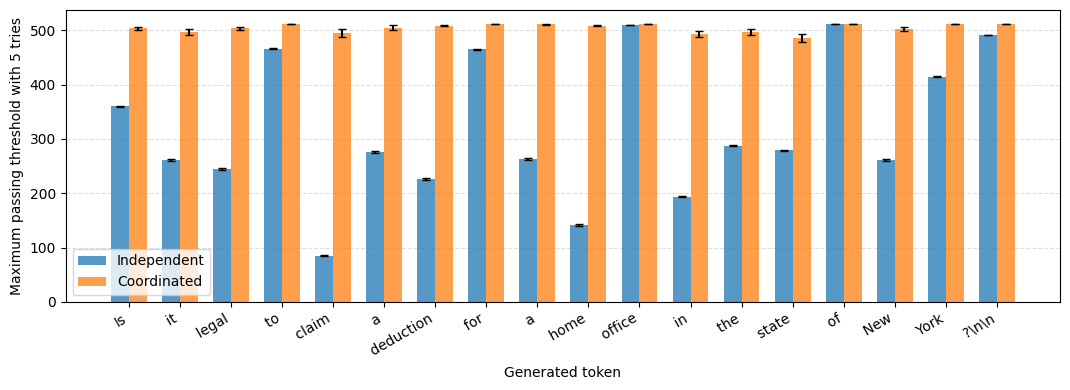

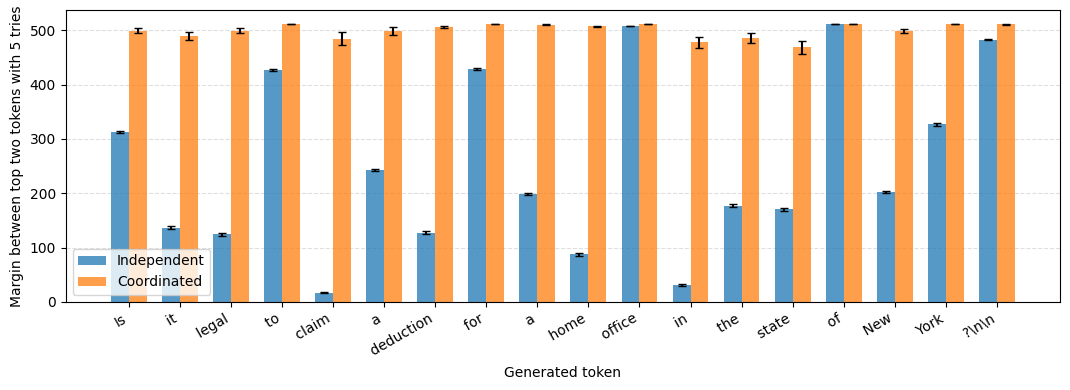

364.5 (1.6) | 505.3 (2.8) | 
266.1 (1.9) | 510.2 (0.5) | Is
249.1 (2.2) | 506.9 (2.0) | Is it
468.0 (1.2) | 512.0 (0.0) | Is it legal
88.6 (1.3) | 508.4 (1.1) | Is it legal to
280.7 (1.2) | 511.9 (0.1) | Is it legal to claim
237.0 (1.0) | 511.8 (0.1) | Is it legal to claim a
469.1 (1.1) | 512.0 (0.0) | Is it legal to claim a deduction
266.3 (1.7) | 511.9 (0.1) | Is it legal to claim a deduction for
142.6 (1.4) | 511.8 (0.2) | Is it legal to claim a deduction for a
510.4 (0.2) | 512.0 (0.0) | Is it legal to claim a deduction for a home
195.3 (2.3) | 507.3 (1.8) | Is it legal to claim a deduction for a home office
289.8 (1.2) | 495.5 (7.4) | Is it legal to claim a deduction for a home office in
281.2 (1.8) | 509.5 (1.1) | Is it legal to claim a deduction for a home office in the
512.0 (0.0) | 512.0 (0.0) | Is it legal to claim a deduction for a home office in the state
264.8 (2.3) | 507.2 (1.3) | Is it legal to claim a deduction for a home office in the state of
420.0 (1.2) | 511.8 (0.1)

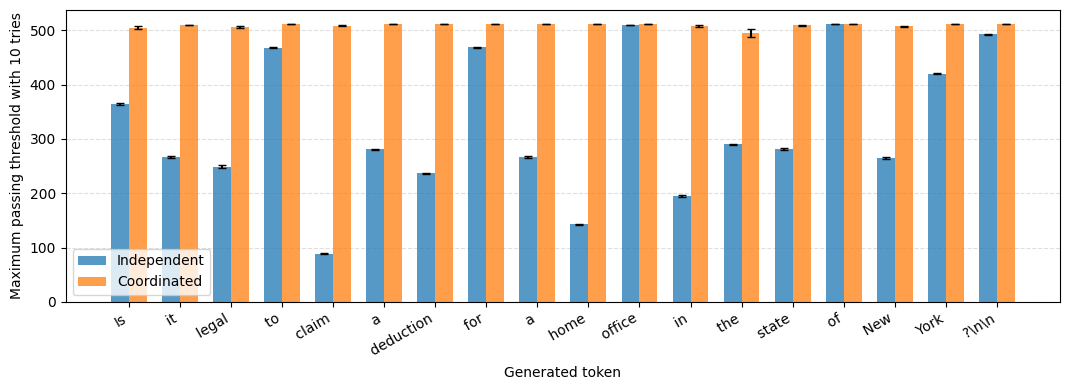

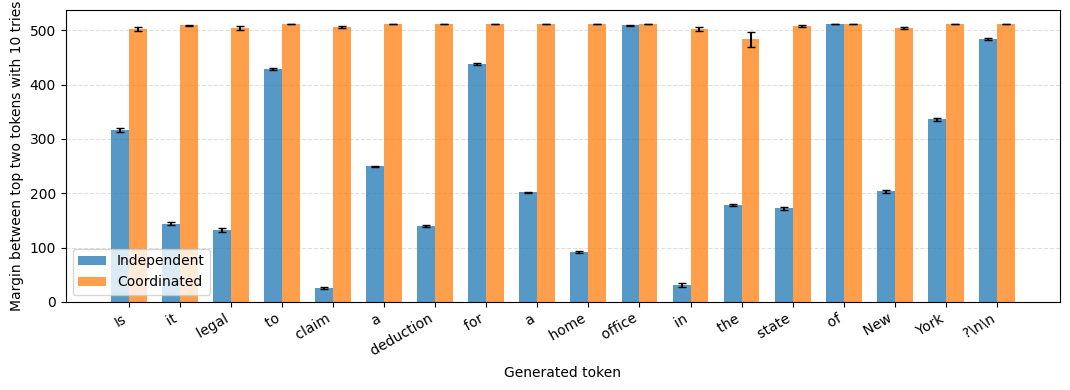

348.4 (1.1) | 433.2 (8.5) | 
190.7 (1.1) | 367.2 (11.2) | How
393.9 (0.9) | 446.8 (6.7) | How can
134.4 (0.8) | 387.2 (10.8) | How can I
320.8 (1.0) | 434.7 (8.5) | How can I change
116.7 (1.0) | 392.0 (10.6) | How can I change the
363.2 (1.1) | 449.7 (7.9) | How can I change the CentOS
425.9 (0.9) | 464.3 (7.5) | How can I change the CentOS 
190.1 (1.0) | 433.9 (9.3) | How can I change the CentOS 7
232.8 (1.3) | 456.6 (8.2) | How can I change the CentOS 7 terminal
294.2 (1.1) | 460.6 (7.4) | How can I change the CentOS 7 terminal font
How can I change the CentOS 7 terminal font?




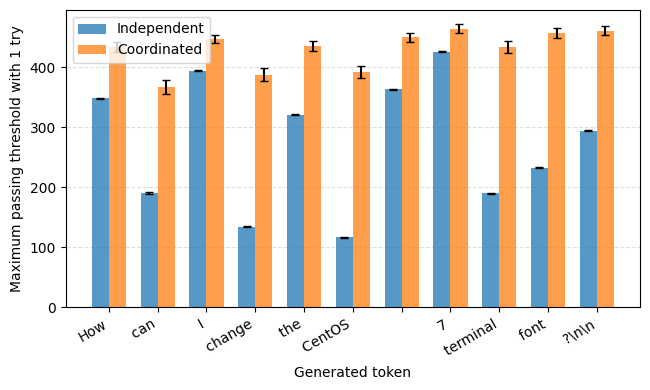

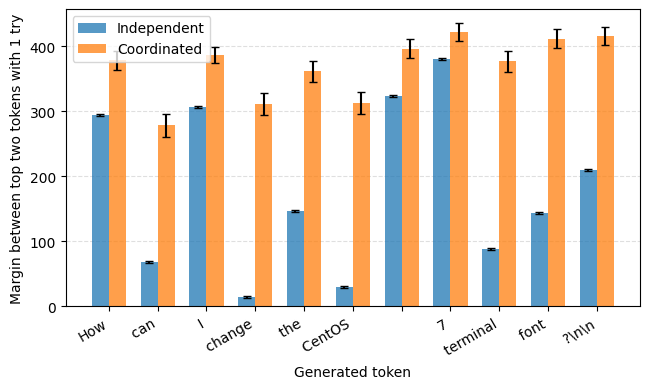

359.4 (1.7) | 498.7 (3.4) | 
200.8 (1.5) | 486.3 (11.8) | How
403.0 (1.2) | 500.9 (3.5) | How can
146.9 (1.8) | 494.6 (4.8) | How can I
327.6 (1.9) | 501.0 (5.5) | How can I change
130.3 (1.7) | 497.2 (5.5) | How can I change the
372.8 (1.2) | 510.6 (0.7) | How can I change the CentOS
434.8 (0.8) | 511.8 (0.1) | How can I change the CentOS 
200.6 (1.2) | 509.7 (1.4) | How can I change the CentOS 7
245.6 (1.6) | 511.9 (0.1) | How can I change the CentOS 7 terminal
309.0 (1.5) | 512.0 (0.0) | How can I change the CentOS 7 terminal font
How can I change the CentOS 7 terminal font?




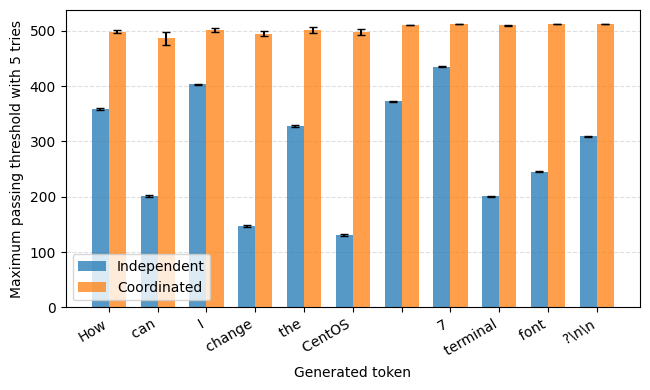

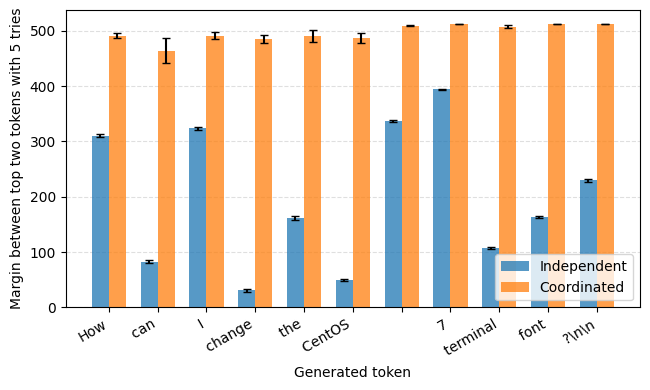

363.4 (2.3) | 509.7 (1.2) | 
206.1 (2.0) | 492.7 (8.8) | How
406.1 (2.6) | 509.7 (1.1) | How can
148.1 (1.2) | 507.9 (1.8) | How can I
329.4 (1.3) | 510.8 (0.7) | How can I change
133.1 (1.8) | 511.6 (0.2) | How can I change the
378.5 (1.6) | 512.0 (0.0) | How can I change the CentOS
440.4 (2.1) | 511.9 (0.1) | How can I change the CentOS 
204.5 (1.9) | 511.9 (0.1) | How can I change the CentOS 7
249.1 (2.4) | 512.0 (0.0) | How can I change the CentOS 7 terminal
312.1 (2.2) | 512.0 (0.0) | How can I change the CentOS 7 terminal font
How can I change the CentOS 7 terminal font?




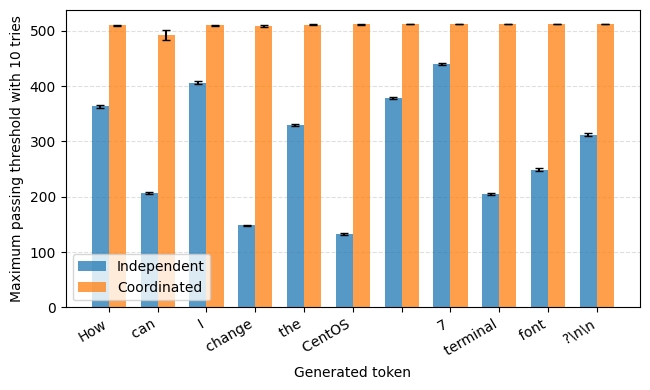

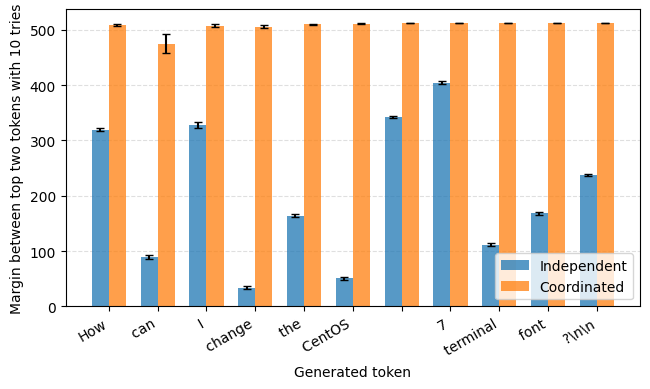

348.0 (1.2) | 400.0 (10.8) | 
369.5 (1.0) | 446.8 (8.6) | What
465.0 (0.6) | 480.6 (5.6) | What is
151.4 (1.0) | 312.8 (9.5) | What is the
160.3 (0.9) | 380.7 (11.3) | What is the most
88.0 (0.8) | 333.9 (11.6) | What is the most powerful
467.1 (0.7) | 495.8 (3.8) | What is the most powerful weapon
489.8 (0.4) | 504.5 (2.1) | What is the most powerful weapon in
440.8 (0.7) | 462.8 (5.8) | What is the most powerful weapon in the
483.8 (0.5) | 483.7 (5.2) | What is the most powerful weapon in the world
What is the most powerful weapon in the world?




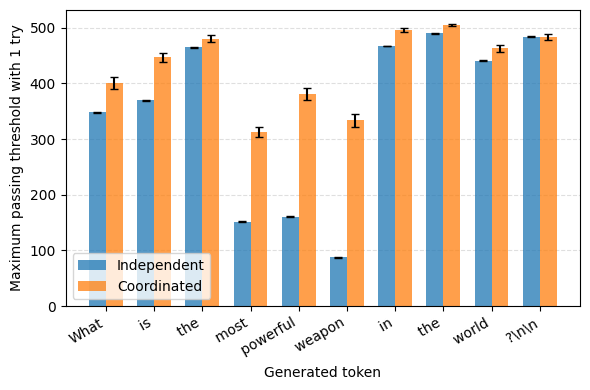

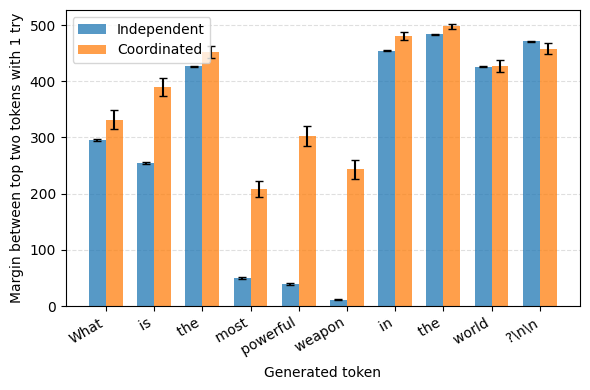

358.5 (1.5) | 497.6 (4.1) | 
380.6 (1.6) | 511.5 (0.3) | What
470.7 (1.0) | 510.9 (0.3) | What is
159.4 (1.4) | 454.2 (10.7) | What is the
170.4 (1.8) | 487.2 (7.6) | What is the most
96.1 (1.2) | 467.3 (11.7) | What is the most powerful
477.1 (0.9) | 512.0 (0.0) | What is the most powerful weapon
494.5 (0.5) | 512.0 (0.1) | What is the most powerful weapon in
447.6 (0.7) | 502.8 (1.8) | What is the most powerful weapon in the
488.9 (0.6) | 510.7 (0.4) | What is the most powerful weapon in the world
What is the most powerful weapon in the world?




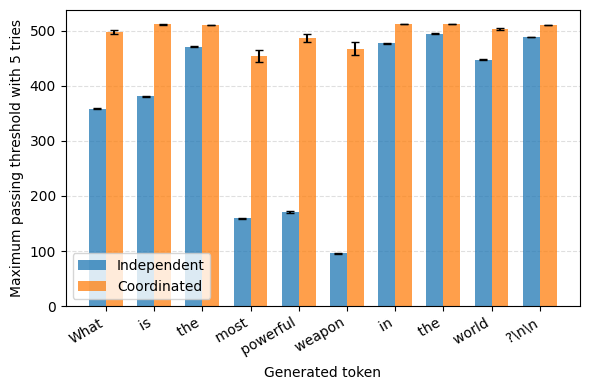

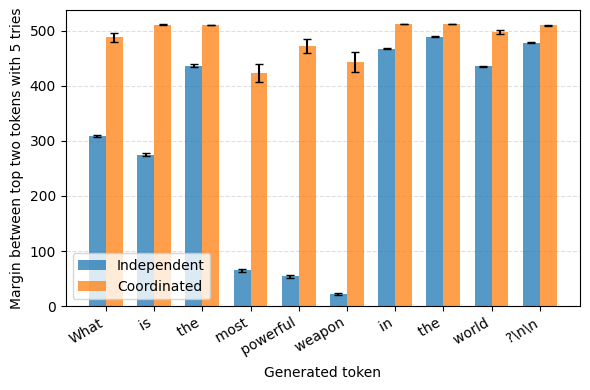

365.8 (1.4) | 510.4 (0.7) | 
387.3 (2.4) | 511.2 (0.7) | What
473.7 (1.3) | 511.9 (0.1) | What is
165.7 (1.3) | 489.7 (10.0) | What is the
176.9 (2.2) | 510.2 (1.7) | What is the most
99.9 (1.5) | 498.6 (5.6) | What is the most powerful
477.2 (1.1) | 512.0 (0.0) | What is the most powerful weapon
496.0 (0.9) | 512.0 (0.0) | What is the most powerful weapon in
450.3 (1.4) | 509.6 (0.8) | What is the most powerful weapon in the
491.0 (0.8) | 511.7 (0.2) | What is the most powerful weapon in the world
What is the most powerful weapon in the world?




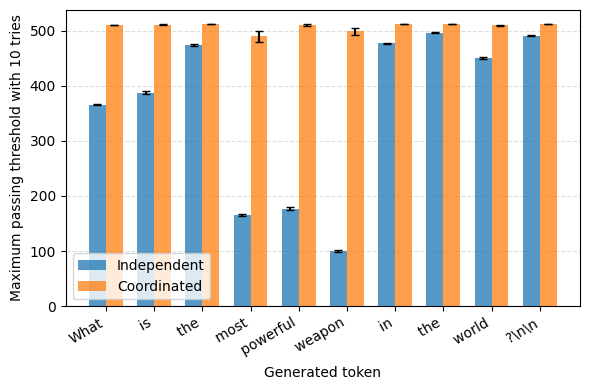

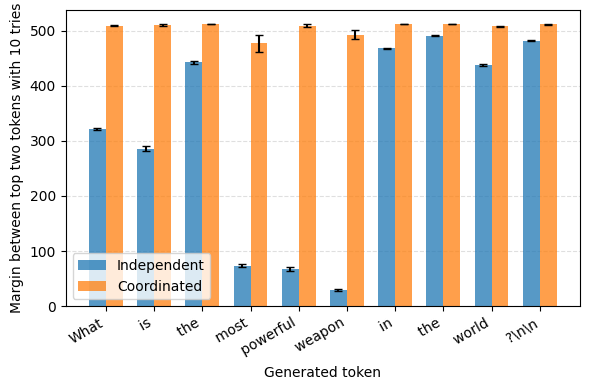

347.8 (1.0) | 415.3 (9.3) | 
370.1 (0.9) | 444.4 (8.1) | What
462.9 (0.6) | 483.3 (5.1) | What is
147.9 (1.0) | 334.1 (10.8) | What is the
511.5 (0.1) | 512.0 (0.0) | What is the difference
422.4 (0.8) | 464.8 (7.2) | What is the difference between
29.1 (0.4) | 304.1 (11.8) | What is the difference between a
181.9 (1.1) | 417.9 (9.7) | What is the difference between a chocolate
477.9 (0.5) | 499.8 (4.4) | What is the difference between a chocolate chip
509.5 (0.1) | 510.3 (1.1) | What is the difference between a chocolate chip cookie
487.7 (0.5) | 504.3 (3.7) | What is the difference between a chocolate chip cookie and
476.4 (0.6) | 495.8 (4.2) | What is the difference between a chocolate chip cookie and a
431.6 (0.8) | 484.8 (5.5) | What is the difference between a chocolate chip cookie and a chocolate
310.3 (0.9) | 454.4 (7.1) | What is the difference between a chocolate chip cookie and a chocolate chip
332.8 (1.0) | 436.0 (8.0) | What is the difference between a chocolate chip cooki

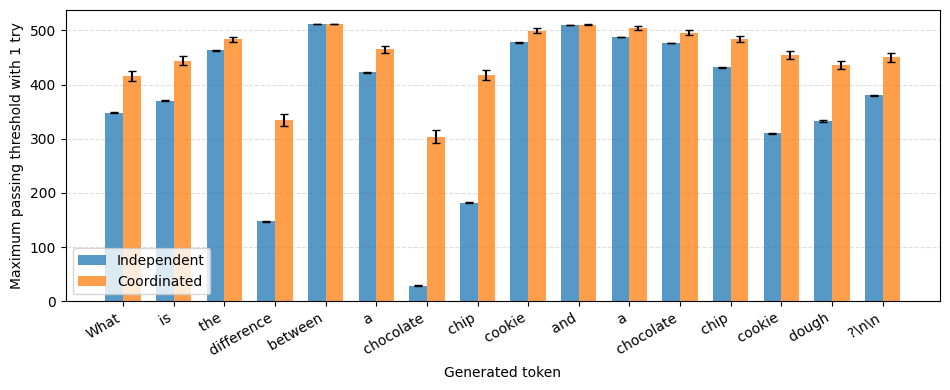

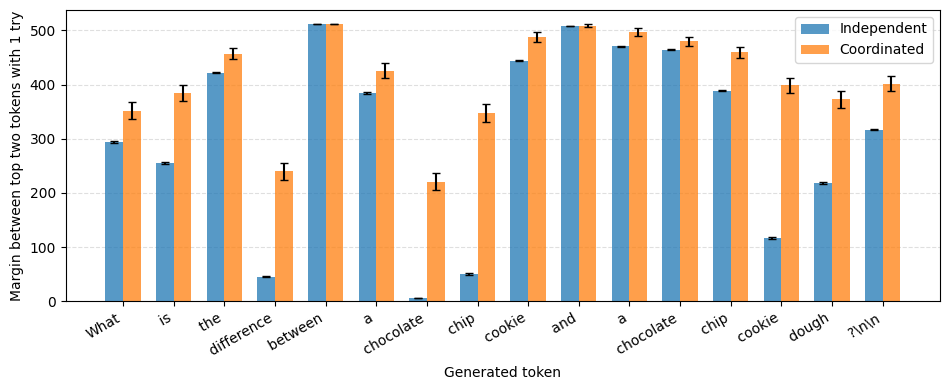

361.9 (1.8) | 507.0 (1.2) | 
380.6 (1.5) | 507.8 (1.3) | What
469.6 (1.1) | 510.8 (0.3) | What is
160.2 (1.5) | 466.9 (10.6) | What is the
512.0 (0.0) | 512.0 (0.0) | What is the difference
431.7 (1.4) | 510.6 (0.4) | What is the difference between
34.7 (0.6) | 440.2 (12.6) | What is the difference between a
194.8 (1.9) | 503.0 (4.1) | What is the difference between a chocolate
485.2 (0.7) | 512.0 (0.0) | What is the difference between a chocolate chip
511.0 (0.2) | 512.0 (0.0) | What is the difference between a chocolate chip cookie
492.6 (0.5) | 512.0 (0.0) | What is the difference between a chocolate chip cookie and
484.1 (0.6) | 512.0 (0.0) | What is the difference between a chocolate chip cookie and a
441.1 (1.1) | 511.9 (0.1) | What is the difference between a chocolate chip cookie and a chocolate
321.2 (1.4) | 511.1 (0.4) | What is the difference between a chocolate chip cookie and a chocolate chip
343.2 (1.0) | 505.3 (2.0) | What is the difference between a chocolate chip cooki

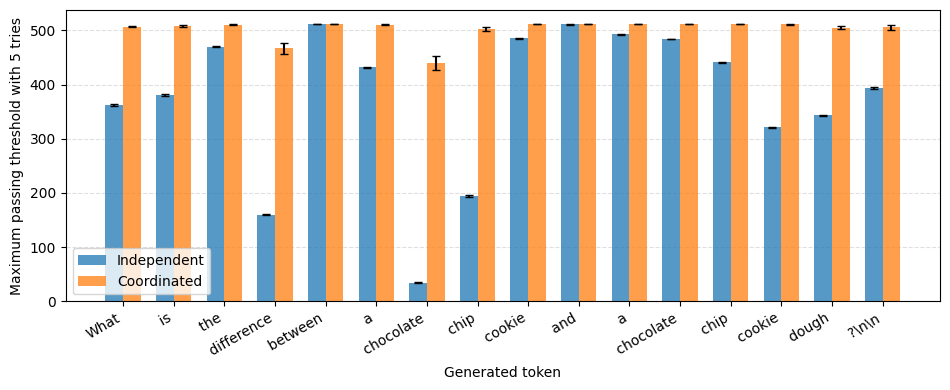

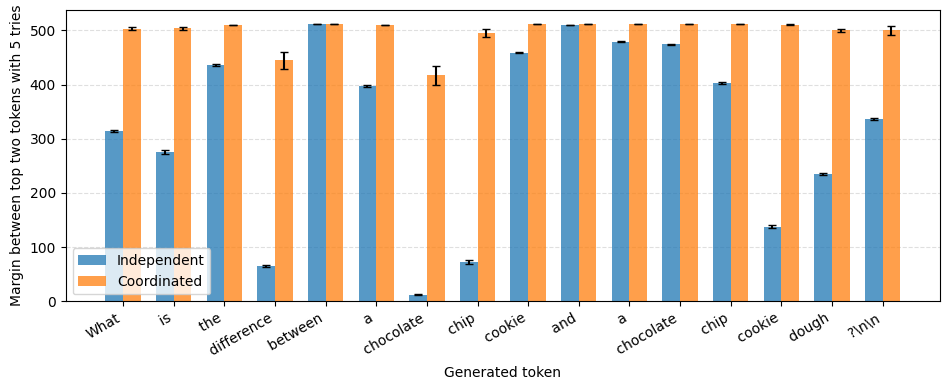

364.1 (1.8) | 508.6 (1.0) | 
383.9 (1.3) | 511.5 (0.5) | What
472.2 (0.8) | 511.9 (0.1) | What is
162.9 (1.4) | 501.6 (5.3) | What is the
512.0 (0.0) | 512.0 (0.0) | What is the difference
436.2 (1.9) | 511.3 (0.4) | What is the difference between
36.8 (1.0) | 490.7 (5.4) | What is the difference between a
199.3 (2.3) | 509.9 (0.9) | What is the difference between a chocolate
486.5 (1.0) | 512.0 (0.0) | What is the difference between a chocolate chip
511.4 (0.2) | 512.0 (0.0) | What is the difference between a chocolate chip cookie
494.7 (0.5) | 512.0 (0.0) | What is the difference between a chocolate chip cookie and
487.6 (1.3) | 512.0 (0.0) | What is the difference between a chocolate chip cookie and a
446.9 (1.1) | 512.0 (0.0) | What is the difference between a chocolate chip cookie and a chocolate
326.3 (3.0) | 510.8 (1.2) | What is the difference between a chocolate chip cookie and a chocolate chip
348.6 (0.9) | 509.6 (1.1) | What is the difference between a chocolate chip cookie 

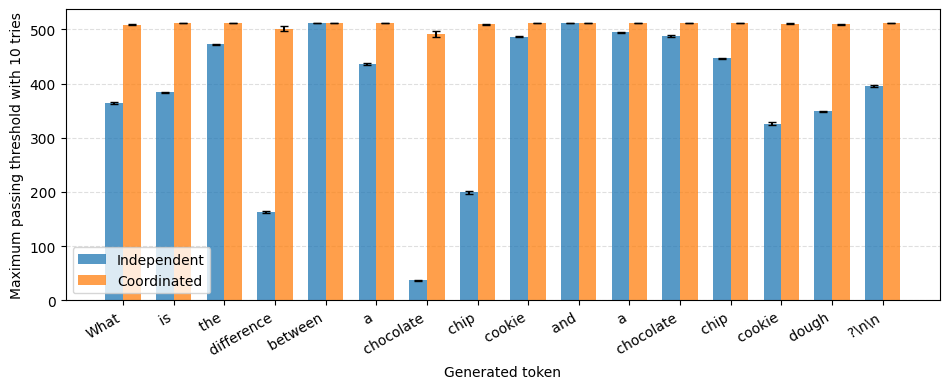

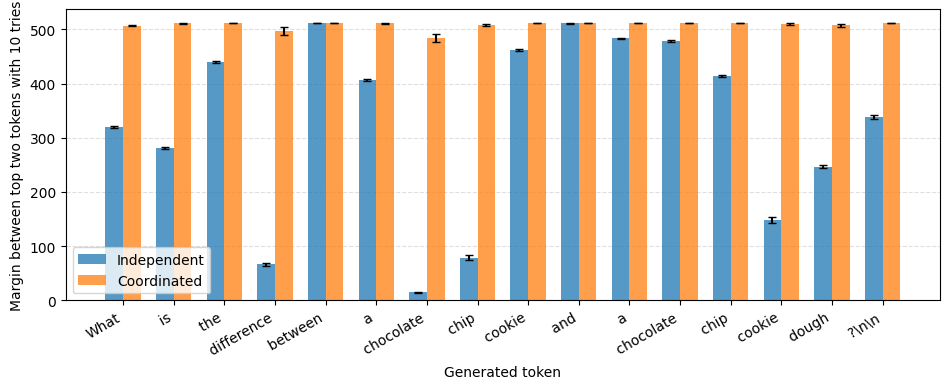

346.6 (1.0) | 435.3 (8.0) | 
369.9 (0.9) | 438.5 (8.4) | What
462.5 (0.6) | 488.3 (4.4) | What is
148.6 (0.9) | 317.4 (9.6) | What is the
511.6 (0.1) | 511.6 (0.4) | What is the difference
422.8 (0.8) | 480.0 (5.4) | What is the difference between
28.6 (0.4) | 292.8 (11.5) | What is the difference between a
491.9 (0.4) | 503.7 (2.9) | What is the difference between a dog
510.0 (0.2) | 512.0 (0.0) | What is the difference between a dog and
312.2 (1.1) | 408.1 (9.3) | What is the difference between a dog and a
477.9 (0.5) | 486.3 (4.6) | What is the difference between a dog and a cat
What is the difference between a dog and a cat?




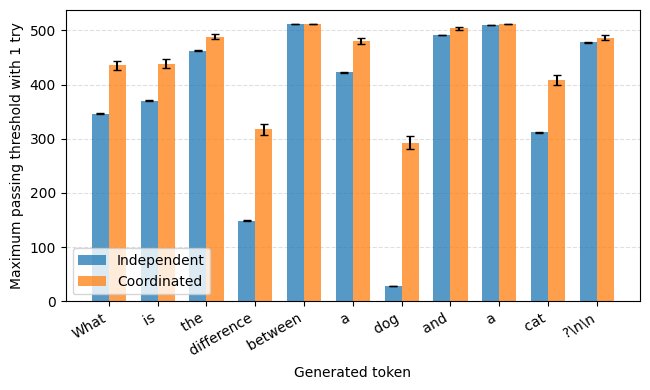

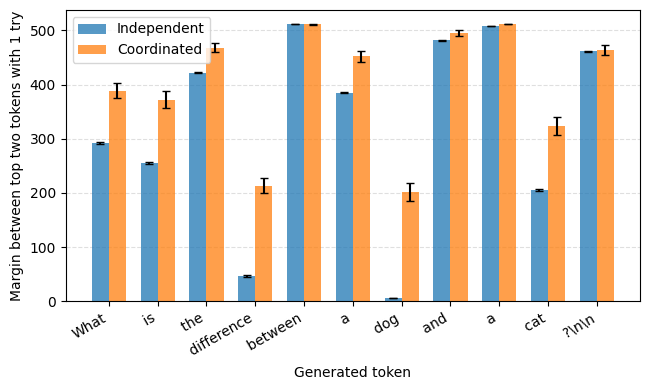

359.6 (1.3) | 501.0 (4.4) | 


In [ ]:
stop_fn = create_stop_fn(tokenizer)
print("Independent Max T | Coordinated Max T | Prefix")

for i in range(10):
    for num_repetitions_for_max_votes in [1, 5, 10]:
        num_samples_for_max_votes = 100 // num_repetitions_for_max_votes
        random_generator = ch.Generator(device=model.device).manual_seed(42 + i)
        prompt_dict = initialize_prompt_dict(teacher_prompts, tokenizer)
        prev_generation = ""
        generated_tokens = []

        ind_max_votes = []
        ind_max_votes_std = []
        coo_max_votes = []
        coo_max_votes_std = []

        ind_max_margins = []
        ind_max_margins_std = []
        coo_max_margins = []
        coo_max_margins_std = []

        while not stop_fn(generated_tokens):
            logits = compute_logits(prompt_dict, model, tokenizer)
            probs = logits_to_probs(logits).mean(dim=0)
            token = ch.multinomial(
                probs, num_samples=1, generator=random_generator
            ).item()

            (
                cur_ind_max_votes,
                cur_ind_max_votes_std,
                cur_ind_max_margins,
                cur_ind_max_margins_std,
            ) = get_max_votes_and_margins(
                logits,
                ind_sampler,
                num_samples_for_max_votes,
                num_repetitions_for_max_votes,
            )
            (
                cur_coo_max_votes,
                cur_coo_max_votes_std,
                cur_coo_max_margins,
                cur_coo_max_margins_std,
            ) = get_max_votes_and_margins(
                logits,
                coo_sampler,
                num_samples_for_max_votes,
                num_repetitions_for_max_votes,
            )

            generated_tokens.append(token)
            update_prompt_dict(prompt_dict, token)
            cur_generation = tokenizer.decode(generated_tokens)
            print(
                f"{cur_ind_max_votes:.1f} ({cur_ind_max_votes_std:.1f})",
                "|",
                f"{cur_coo_max_votes:.1f} ({cur_coo_max_votes_std:.1f})",
                "|",
                prev_generation,
            )
            ind_max_votes.append(cur_ind_max_votes)
            ind_max_votes_std.append(cur_ind_max_votes_std)
            coo_max_votes.append(cur_coo_max_votes)
            coo_max_votes_std.append(cur_coo_max_votes_std)

            ind_max_margins.append(cur_ind_max_margins)
            ind_max_margins_std.append(cur_ind_max_margins_std)
            coo_max_margins.append(cur_coo_max_margins)
            coo_max_margins_std.append(cur_coo_max_margins_std)

            prev_generation = cur_generation
        print(cur_generation)
        save_path = (
            Path("outputs")
            / f"max_passing_threshold_{num_repetitions_for_max_votes}_retries"
            / f"sample_{i}.pdf"
        )
        plot_max_metrics(
            "Maximum passing threshold",
            ind_max_votes,
            ind_max_votes_std,
            coo_max_votes,
            coo_max_votes_std,
            generated_tokens,
            tokenizer,
            save_path=save_path,
            num_repetitions_for_max_votes=num_repetitions_for_max_votes,
        )
        save_path = (
            Path("outputs")
            / f"max_margin_{num_repetitions_for_max_votes}_retries"
            / f"sample_{i}.pdf"
        )
        plot_max_metrics(
            "Margin between top two tokens",
            ind_max_margins,
            ind_max_margins_std,
            coo_max_margins,
            coo_max_margins_std,
            generated_tokens,
            tokenizer,
            save_path=save_path,
            num_repetitions_for_max_votes=num_repetitions_for_max_votes,
        )